In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [4]:
# 3x3
#Flags

KFolds = 10
rotateToTop = False

#Only one should be selected
original = False #Same than 5x5
preOriginal = False #Same than 5x5 
original_preOriginal = False
rawDigEi = False
rawCLEi = True
rawCLEi_and_preOriginal = False
rawCLEi_and_original = False

rawDigEi_and_original = False
rawCLEi_and_original_and_preOriginal = False


#For plotting Clusters
plot_analysis = False

#For saving boosters and their results. If selected you must specify the following variables
save_results = True


if rawCLEi:
    folder = '3x3_RawClEi'
    title = '3x3 Raw ClEi Data'
elif rawDigEi:
    folder = '3x3_RawDigEi'
    title = '3x3 Raw DigEi Data'
elif original:
    folder = 'Original'
    title = 'Original Data'
elif preOriginal:
    folder = 'preOriginal'
    title = 'PreOriginal Data'
elif rawCLEi_and_original:
    folder = '3x3_RawCLEi_and_original'
    title = '3x3 Raw ClEi & Original Data'
elif rawDigEi_and_original:
    folder = '3x3_RawDigEi_and_original'
    title = '3x3 Raw DigEi & Original Data'
elif rawCLEi_and_preOriginal:
    folder = '3x3_rawCLEi_and_preOriginal'
    title = '3x3 Raw ClEi & PreOriginal Data'
elif rawCLEi_and_original_and_preOriginal:
    folder = '3x3_RawCLEi_and_original_and_preOriginal'
    title = '3x3 Raw ClEi & Original & PreOriginal Data'
elif original_preOriginal:
    folder = 'original_preOriginal'
    title = 'Original & PreOriginal Data'


if rotateToTop:
    #Path to save the boosters
    save_models_path = './boost_models/%s' % folder
    #Path to save the boosters image results
    save_results_path = './Outputs/%s/' % folder
else:
    #Path to save the boosters
    save_models_path = './boost_models/Unp%s/' % folder
    #Path to save the boosters image results
    save_results_path = './Outputs/Unp%s/' % folder

In [5]:
#Load Data
photons_data = pd.read_csv('../data/MCUpgrade_photons_5x5.dat', sep='\t')
mergedpi_data = pd.read_csv('../data/MCUpgrade_mergedpi0_5x5.dat', sep='\t')
photons_data.columns = ['p', 'pt', 'eta', 'area', 'nPVs', 'ClusterE', 'ClusterE9',
       'ClE1', 'ClE2', 'ClE3', 'ClE4', 'ClE5', 'ClE6', 'ClE7',
       'ClE8', 'ClE9', 'ClE10', 'ClE11', 'ClE12', 'ClE13',
       'ClE14', 'ClE15', 'ClE16', 'ClE17', 'ClE18', 'ClE19',
       'ClE20', 'ClE21', 'ClE22', 'ClE23', 'ClE24', 'ClE25',
       'DigE1', 'DigE2', 'DigE3', 'DigE4', 'DigE5', 'DigE6',
       'DigE7', 'DigE8', 'DigE9', 'DigE10', 'DigE11', 'DigE12',
       'DigE13', 'DigE14', 'DigE15', 'DigE16', 'DigE17', 'DigE18',
       'DigE19', 'DigE20', 'DigE21', 'DigE22', 'DigE23', 'DigE24',
       'DigE25', 'isPhr2', 'isPhr2r4', 'isPhasym', 'isPhkappa',
       'isPhEseed', 'isPhE2', 'Sxx', 'Sxy', 'Syy']
mergedpi_data.columns = ['p', 'pt', 'eta', 'area', 'nPVs', 'ClusterE', 'ClusterE9',
       'ClE1', 'ClE2', 'ClE3', 'ClE4', 'ClE5', 'ClE6', 'ClE7',
       'ClE8', 'ClE9', 'ClE10', 'ClE11', 'ClE12', 'ClE13',
       'ClE14', 'ClE15', 'ClE16', 'ClE17', 'ClE18', 'ClE19',
       'ClE20', 'ClE21', 'ClE22', 'ClE23', 'ClE24', 'ClE25',
       'DigE1', 'DigE2', 'DigE3', 'DigE4', 'DigE5', 'DigE6',
       'DigE7', 'DigE8', 'DigE9', 'DigE10', 'DigE11', 'DigE12',
       'DigE13', 'DigE14', 'DigE15', 'DigE16', 'DigE17', 'DigE18',
       'DigE19', 'DigE20', 'DigE21', 'DigE22', 'DigE23', 'DigE24',
       'DigE25', 'isPhr2', 'isPhr2r4', 'isPhasym', 'isPhkappa',
       'isPhEseed', 'isPhE2', 'Sxx', 'Sxy', 'Syy']

# Define Cluster Shape..
  

In [6]:
if rawCLEi:
    final_shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19']
    shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19']
elif rawDigEi:
    final_shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19']
    shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19']
elif original:
    final_shape = ['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']
    shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19']
elif preOriginal:
    final_shape = ['Sxx', 'Sxy', 'Syy']
    shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19']
elif rawCLEi_and_original:
    final_shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19','isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']
    shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19']
elif rawDigEi_and_original:
    final_shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19','isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']
    shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19']
elif rawCLEi_and_preOriginal:
    final_shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19','Sxx', 'Sxy', 'Syy']
    shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19']
elif rawCLEi_and_original_and_preOriginal:
    final_shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19','isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2','Sxx', 'Sxy', 'Syy']
    shape = ['ClE7', 'ClE8', 'ClE9', 'ClE12', 'ClE13', 'ClE14', 'ClE17', 'ClE18', 'ClE19']
elif original_preOriginal:
    final_shape = ['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2','Sxx', 'Sxy', 'Syy']
    shape = ['DigE7', 'DigE8', 'DigE9', 'DigE12',
       'DigE13', 'DigE14', 'DigE17', 'DigE18',
       'DigE19']
# Original + Raw
# final_shape = ['ClE1','ClE2','ClE3','ClE4','ClE5','ClE6','ClE7','ClE8','ClE9','isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']
#Raw
#final_shape = ['ClE1', 'ClE2', 'ClE3', 'ClE4', 'ClE5', 'ClE6', 'ClE7', 'ClE8', 'ClE9', 'ClE10', 'ClE11', 'ClE12', 'ClE13', 'ClE14', 'ClE15', 'ClE16', 'ClE17', 'ClE18', 'ClE19', 'ClE20', 'ClE21', 'ClE22', 'ClE23', 'ClE24', 'ClE25']
# Original
#final_shape = ['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']
#shape = ['ClE1', 'ClE2', 'ClE3', 'ClE4', 'ClE5', 'ClE6', 'ClE7', 'ClE8', 'ClE9', 'ClE10', 'ClE11', 'ClE12', 'ClE13', 'ClE14', 'ClE15', 'ClE16', 'ClE17', 'ClE18', 'ClE19', 'ClE20', 'ClE21', 'ClE22', 'ClE23', 'ClE24', 'ClE25']

# Prepare Data..
- 0) Retrieve RAW data
- 1) Rotate RAW matrices
- 2) Normalise data
- 3) Add Original Variables to data
- 4) Add Labels to data
- 5) Equilibrate category classes
- 6) Merge both merged pi0 and photons data into single panda DataFrame -

In [7]:
# -0
m_d = pd.DataFrame()
p_d = pd.DataFrame()
data = pd.DataFrame()
#Retrive important columns
p_d = photons_data[list (shape)]
m_d = mergedpi_data[list (shape)]

In [8]:
def rotate_to_top_matrice(m):
    max = 0
    
    top = m[0][1]
    bot = m[2][1]
    left = m[1][0]
    right = m[1][2]
    
    if (top > bot) & (top > left) & (top > right):
        max = 0
    elif (bot > left) & (bot > right):
        max = 2
    elif left > right:
        max = 3
    else:
        max = 1
    
    mat = np.rot90(m, max)

    top = mat[0][1]
    top_left = mat[0][0]
    top_right = mat[0][2]
    bot_left = mat[2][0]
    bot_right = mat[2][2]
    max = 0
    if (top_left >= top_right) & (top_left >= bot_left) & (top_left >= bot_right) & (top_left > top):
        max = 0
    elif (top_right >= bot_left) & (top_right >= bot_right) & (top_right > top):
        max = 1
    elif (bot_left >= bot_right) & (bot_left > top):
        max = 3
    elif bot_right > top:
        max = 2
         
    
    return np.rot90(mat, max)

In [9]:
if rotateToTop:
    # -1
    # Rotate matrices to top direction
    p_d = pd.DataFrame(np.array([rotate_to_top_matrice(m) for m in p_d.values.reshape((-1, 3, 3, 1))]).reshape(-1,9))
    p_d.columns = shape
    m_d = pd.DataFrame(np.array([rotate_to_top_matrice(m) for m in m_d.values.reshape((-1, 3, 3, 1))]).reshape(-1,9))
    m_d.columns = shape
# -2
#Normalise data
    #Divide each cell with the entire energy at the cluster
p_d = p_d[shape]
m_d = m_d[shape]
p_d = p_d.assign(suma = p_d.sum(axis=1));
m_d = m_d.assign(suma = m_d.sum(axis=1));
p_d_norm = (p_d.T / p_d.suma).T
m_d_norm = (m_d.T / m_d.suma).T


In [10]:

if original | rawCLEi_and_original | rawDigEi_and_original:
    m_d_norm[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']] = mergedpi_data[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']]
    p_d_norm[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']] = photons_data[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2']]
elif preOriginal | rawCLEi_and_preOriginal:
    m_d_norm[['Sxx', 'Sxy', 'Syy']] = mergedpi_data[['Sxx', 'Sxy', 'Syy']]
    p_d_norm[['Sxx', 'Sxy', 'Syy']] = photons_data[['Sxx', 'Sxy', 'Syy']]

if rawCLEi_and_original_and_preOriginal | original_preOriginal:
    m_d_norm[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2','Sxx', 'Sxy', 'Syy']] = mergedpi_data[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2','Sxx', 'Sxy', 'Syy']]
    p_d_norm[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2','Sxx', 'Sxy', 'Syy']] = photons_data[['isPhr2','isPhr2r4','isPhasym','isPhkappa','isPhEseed','isPhE2','Sxx', 'Sxy', 'Syy']]
    
    
    

In [11]:
# -4
#Add Labels to data
m_d_norm['area'] = mergedpi_data[['area']]
p_d_norm['area'] = photons_data[['area']]

#Add category = 0 column to dataframe, so we identify merged pi0 as 0
m_d_norm = m_d_norm.assign(category=pd.Series(np.full((len(m_d_norm['area'])), 0)).values)

#Add category = 1 column to dataframe, so we identify photons as 1
p_d_norm = p_d_norm.assign(category=pd.Series(np.full((len(p_d_norm['area'])), 1)).values)

In [12]:
# -5 
# Equilibrate category classes
p_d_norm_0 = p_d_norm[p_d_norm['area'] == 0]
p_d_norm_0 = p_d_norm_0.iloc[0:len(m_d_norm[m_d_norm['area'] == 0])]

p_d_norm_1 = p_d_norm[p_d_norm['area'] == 1]
p_d_norm_1 = p_d_norm_1.iloc[0:len(m_d_norm[m_d_norm['area'] == 1])]

p_d_norm_2 = p_d_norm[p_d_norm['area'] == 2]
p_d_norm_2 = p_d_norm_2.iloc[0:len(m_d_norm[m_d_norm['area'] == 2])]

print (len(p_d_norm_0) + len(p_d_norm_1) + len(p_d_norm_2) == len(m_d_norm))
p_d_norm = p_d_norm_0.append(p_d_norm_1).append(p_d_norm_2)



True


In [13]:
# -6
#Merge both mergedpi0 and photons into a single datagrame
data = m_d_norm.append(p_d_norm)

# DATA ANALYZED

In [14]:
def plot_cluster_comparasion(weight_0, weight_1, title_0, title_1):
    f, (ax) = plt.subplots(1, 2, figsize=(12,5),sharex=True, sharey=True, constrained_layout=True)
    levels = np.linspace(0, 1)
    ax[0].set_title(title_0)
    ax[1].set_title(title_1)
    im = ax[0].hist2d(x, y, (3, 3), weights=weight_0, cmap=plt.cm.jet, vmin=0, vmax=1)
    ax[1].hist2d(x, y, (3, 3), weights=weight_1, cmap=plt.cm.jet,vmin=0, vmax=1)

    plt.colorbar(im[3]);


    plt.show()

if plot_analysis:

    x = [i for range_set in range(3) for i in range (1,4)]
    y = sorted(x, reverse=True)

    single_m_0 = np.array(m_d_norm[m_d_norm['area'] == 0][shape])[0]
    single_m_1 = np.array(m_d_norm[m_d_norm['area'] == 1][shape])[0]
    single_m_2 = np.array(m_d_norm[m_d_norm['area'] == 2][shape])[0]

    single_p_0 = np.array(p_d_norm[p_d_norm['area'] == 0][shape])[0]
    single_p_1 = np.array(p_d_norm[p_d_norm['area'] == 1][shape])[0]
    single_p_2 = np.array(p_d_norm[p_d_norm['area'] == 2][shape])[2]


    mean_m_0 = (m_d_norm[m_d_norm['area'] == 0][shape].values).mean(axis=0)
    mean_m_1 = (m_d_norm[m_d_norm['area'] == 1][shape].values).mean(axis=0)
    mean_m_2 = (m_d_norm[m_d_norm['area'] == 2][shape].values).mean(axis=0)

    mean_p_0 = (p_d_norm[p_d_norm['area'] == 0][shape].values).mean(axis=0)
    mean_p_1 = (p_d_norm[p_d_norm['area'] == 1][shape].values).mean(axis=0)
    mean_p_2 = (p_d_norm[p_d_norm['area'] == 2][shape].values).mean(axis=0)
    
    
    plot_cluster_comparasion(mean_m_0, mean_p_0, "Outer $\pi^0$ mean cluster\n", "Outer $\gamma$ mean cluster\n")
    plot_cluster_comparasion(mean_m_1, mean_p_1, "Middle $\pi^0$ mean cluster\n", "Middle $\gamma$ mean cluster\n")
    plot_cluster_comparasion(mean_m_2, mean_p_2, "Inner $\gamma$ mean cluster\n", "Inner $\gamma$ mean cluster\n")
    plot_cluster_comparasion(single_m_0, single_p_0, "Outer $\pi^0$ cluster\n", "Outer $\gamma$ cluster\n")
    plot_cluster_comparasion(single_m_1, single_p_1, "Middle $\pi^0$ cluster\n", "Middle $\gamma$ cluster\n")
    plot_cluster_comparasion(single_m_2, single_p_2, "Inner $\pi^0$ cluster\n", "Inner $\gamma$ cluster\n")




# XGBoost..
- 0) Divide into train and test
- 1) Fit into DMatrix
- 2) CrossValidation
- 3) Train!
- 4) Test
- 5) Plot

In [15]:
#Function to divide data
#Param area [0,1,2] ECAL area
#test_fraction, the fraction of data to preserve for test
def divide_data(area, test_fraction):
    X_train, X_test, y_train, y_test = train_test_split(data[data['area'] == area][final_shape],
                                                data[data['area'] == area][['category']], test_size=test_fraction, random_state=0)
    return X_train, X_test, y_train, y_test

DMatrix object takes as arguments:
- data --- the features
- label --- 1/0 or true/false for binary data (so set 0 = merged pi 0, 1 = photon)
- feature_names --- the names of all of the features (optional)

In [16]:
def fit_data(X_train, X_test, y_train, y_test):
    feature_names=final_shape
    train = xgb.DMatrix(data=X_train,label=y_train,feature_names=feature_names)
    test = xgb.DMatrix(data=X_test,label=y_test,feature_names=feature_names)
    return train, test


In [17]:
#Tree parameters
param = {'eta': 0.02, 
          'max_depth': 10, 
          'subsample': 0.8, 
          'colsample_bytree': 0.8, 
          'objective': 'binary:logistic', 
          'seed': 0, 
          'silent': 1,
         'eval_metric': 'auc'}

early_stopping = 10
num_trees = 1000  # number of trees to make

In [18]:
#CV + XGBoost train
def train_tree(param, n_folds, early_stopping, num_trees, train):
    #cv = xgb.cv(param, train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping)
   # print (param)
    booster = xgb.train(param,train,num_boost_round=num_trees)
    return booster

def test_tree(booster, test):
    #Predict test results
    predictions = booster.predict(test)
    return predictions

def plot_category_predictions(predictions, test, area, fold, data_title = title):
    
    #xgb.plot_importance(booster,grid=True);
    
    fig = plt.figure(figsize=(20,10));
    plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
             histtype='step',color='midnightblue',label='$\gamma$');
    plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
             histtype='step',color='firebrick',label='$\pi$');
    # make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Samples',fontsize=12);
    plt.legend(frameon=False);
    plt.title("%s Area; Fold %d; %s; XGBoost" % (area, fold, data_title) ,fontsize=13);
    return fig

def CV_xgboost_tree_from_trained_booster(X, Y, booster, nsplits = KFolds):

    cv = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state = 42)
    
    tprs = []
    aucs = []
    i = 0
    tests = []
    predictions = []
    mean_fpr = np.linspace(0, 1, 100)
    fig = plt.figure(figsize=(10,10))
    for itrain, itest in cv.split(X, Y):
        train, test = fit_data(np.array(X.iloc[itrain]), np.array(X.iloc[itest]),np.array(Y.iloc[itrain]), np.array(Y.iloc[itest]))
        tests.append(test)
        predictions.append(booster[i].predict(test))
        #plot_results(booster[i], predictions, 'XGBoost; outter area; Raw Data')
        #xgb.plot_importance(booster[i],grid=True);
        fpr, tpr, threshold = metrics.roc_curve(np.array(Y.iloc[itest]), predictions[i])

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
       
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    

    
    return predictions, tests, mean_fpr, mean_tpr, mean_auc, std_auc, plt, fig

def CV_xgboost_tree(X, Y, nsplits = KFolds):

    cv = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state = 42)
    
    tprs = []
    aucs = []
    i = 0
    booster = []
    predictions = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    for itrain, itest in cv.split(X, Y):
        train, test = fit_data(np.array(X.iloc[itrain]), np.array(X.iloc[itest]),np.array(Y.iloc[itrain]), np.array(Y.iloc[itest]))
        booster.append(xgb.train(param,train,num_boost_round=num_trees))
        predictions.append(booster[i].predict(test))
        
        #plot_results(booster[i], predictions, 'XGBoost; outter area; Raw Data')
        #xgb.plot_importance(booster[i],grid=True);
        fpr, tpr, threshold = metrics.roc_curve(np.array(Y.iloc[itest]), predictions[i])

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        print(i)
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    

    
    return booster, predictions, mean_fpr, mean_tpr, mean_auc, std_auc, plt


def plot_results(mean_fpr, mean_tpr, mean_auc, std_auc, plot, color, title):
    plot.plot(mean_fpr, mean_tpr, color=color, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    plot.xlim([-0.01, 1.01])
    plot.ylim([-0.01, 1.01])
    plot.legend(loc = 'lower right')
    plot.ylabel('$\gamma$ efficiency')
    plot.xlabel('$\pi^0$ efficiency')
    plot.title(title)
    plot.show()
    
def save_models():
    for i in range(KFolds):
        out_boosters[i].save_model('%s/0_Fold%d_.model' % (save_boosters_path, i))
        mid_boosters[i].save_model('%s/1_Fold%d_.model' % (save_boosters_path, i))
        in_boosters[i].save_model('%s/2_Fold%d_.model' % (save_boosters_path, i))

def load_models():
    out_boosters = []
    mid_boosters = []
    in_boosters = []
    for i in range(KFolds):
        out_boosters.append(xgb.Booster({'nthread': 4}))  # init model
        out_boosters[i].load_model('%s/0_Fold%d_.model' % (save_boosters_path, i))  # load data
        mid_boosters.append(xgb.Booster({'nthread': 4}))  # init model
        mid_boosters[i].load_model('%s/1_Fold%d_.model' % (save_boosters_path, i))  # load data
        in_boosters.append(xgb.Booster({'nthread': 4}))  # init model
        in_boosters[i].load_model('%s/2_Fold%d_.model' % (save_boosters_path, i))  # load data
    return out_boosters, mid_boosters, in_boosters

  
def reproduce_results(path, data_title = title):
    out_boosters, mid_boosters, in_boosters = load_models()
    X_train, X_test, y_train, y_test = divide_data(2,0)
    in_predictions, in_tests, in_mean_fpr, in_mean_tpr, in_mean_auc, in_std_auc, in_plot, in_fig = CV_xgboost_tree_from_trained_booster(X_train,y_train,in_boosters, KFolds)
    plot_results(in_mean_fpr, in_mean_tpr, in_mean_auc, in_std_auc, in_plot, 'b', "Inner Area; %s; XGBoost" % data_title)
    in_fig.savefig('%s2.png' % (path))
    for i in range(KFolds):
        in_fig = plot_category_predictions(in_predictions[i], in_tests[i], 'Inner', i)
        in_fig.savefig('%s2_fold%d.png' % (path,i))
        
    X_train, X_test, y_train, y_test = divide_data(1,0)
    mid_predictions, mid_tests, mid_mean_fpr, mid_mean_tpr, mid_mean_auc, mid_std_auc, mid_plot, mid_fig = CV_xgboost_tree_from_trained_booster(X_train,y_train, mid_boosters, KFolds)
    plot_results(mid_mean_fpr, mid_mean_tpr, mid_mean_auc, mid_std_auc, mid_plot, 'g', "Middle Area; %s; XGBoost" % data_title)
    mid_fig.savefig('%s1.png' % (path))
    for i in range(KFolds):
        mid_fig = plot_category_predictions(mid_predictions[i], mid_tests[i], 'Middle', i)
        mid_fig.savefig('%s1_fold%d.png' % (path,i))
    
    X_train, X_test, y_train, y_test = divide_data(0,0)
    out_predictions, out_tests, out_mean_fpr, out_mean_tpr, out_mean_auc, out_std_auc, out_plot, out_fig = CV_xgboost_tree_from_trained_booster(X_train,y_train, out_boosters, KFolds)
    plot_results(out_mean_fpr, out_mean_tpr, out_mean_auc, out_std_auc, out_plot, 'r', "Outer Area; %s; XGBoost" % data_title)
    out_fig.savefig('%s0.png' % (path))
    for i in range(KFolds):
        out_fig = plot_category_predictions(out_predictions[i], out_tests[i], 'Outer', i)
        out_fig.savefig('%s0_fold%d.png' % (path,i))
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    tprs.append(interp(mean_fpr, in_mean_fpr, in_mean_tpr))
    tprs[-1][0] = 0.0
    aucs.append(in_mean_auc)

    tprs.append(interp(mean_fpr, out_mean_fpr, out_mean_tpr))
    tprs[-1][0] = 0.0
    aucs.append(out_mean_auc)

    tprs.append(interp(mean_fpr, mid_mean_fpr, mid_mean_tpr))
    tprs[-1][0] = 0.0
    aucs.append(mid_mean_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)


    final_fig = plt.figure(figsize=(10,10))

    plt.plot(out_mean_fpr, out_mean_tpr, color='r', label=r'Outer Area Mean ROC (AUC = %0.2f)' % (out_mean_auc),
                 lw=2, alpha=.8)
    plt.plot(mid_mean_fpr, mid_mean_tpr, color='g', label=r'Middle Area Mean ROC (AUC = %0.2f)' % (mid_mean_auc),
                 lw=2, alpha=.8)
    plt.plot(in_mean_fpr, in_mean_tpr, color='b', label=r'Inner Area Mean ROC (AUC = %0.2f)' % (in_mean_auc),
                 lw=2, alpha=.8)
    plt.plot(mean_fpr, mean_tpr, color='c', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.legend(loc = 'lower right')
    plt.title('XGBoost; %s; Mean AUC' % data_title)
    plt.ylabel('$\gamma$ efficiency')
    plt.xlabel('$\pi^0$ efficiency')
    final_fig.savefig('%s0_1_2.png' % path)





0
1
2


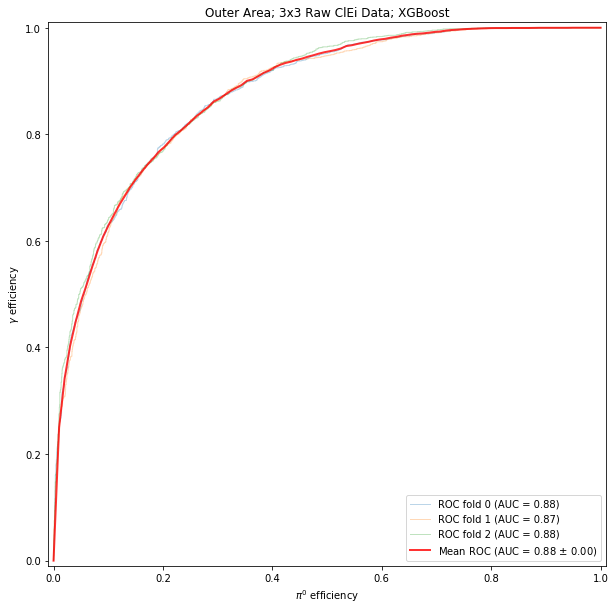

In [19]:
X_train, X_test, y_train, y_test = divide_data(0,0) # IMPORTANT IT ALSO ROTATES DATA
out_boosters, out_predictions, out_mean_fpr, out_mean_tpr, out_mean_auc, out_std_auc, out_plot = CV_xgboost_tree(X_train,y_train, 3)

plot_results(out_mean_fpr, out_mean_tpr, out_mean_auc, out_std_auc, out_plot, 'r', "Outer Area; %s; XGBoost" % title)


0
1
2
3
4
5
6
7
8
9


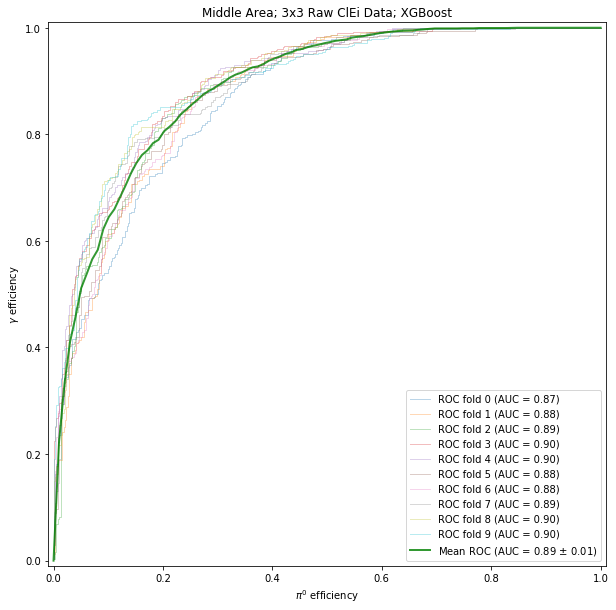

In [20]:
X_train, X_test, y_train, y_test = divide_data(1,0) # IMPORTANT IT ALSO ROTATES DATA
mid_boosters, mid_predictions, mid_mean_fpr, mid_mean_tpr, mid_mean_auc, mid_std_auc, mid_plot = CV_xgboost_tree(X_train,y_train, KFolds)

plot_results(mid_mean_fpr, mid_mean_tpr, mid_mean_auc, mid_std_auc, mid_plot, 'g', "Middle Area; %s; XGBoost" % title)


0
1
2
3
4
5
6
7
8
9


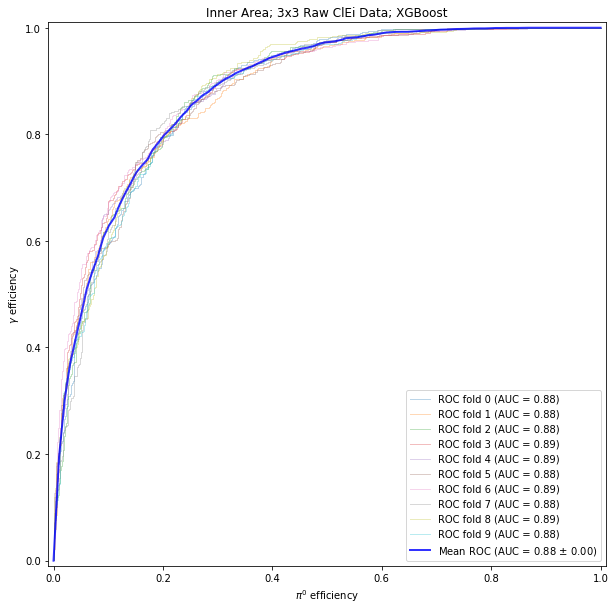

In [21]:
X_train, X_test, y_train, y_test = divide_data(2,0) # IMPORTANT IT ALSO ROTATES DATA
in_boosters, in_predictions, in_mean_fpr, in_mean_tpr, in_mean_auc, in_std_auc, in_plot = CV_xgboost_tree(X_train,y_train, KFolds)

plot_results(in_mean_fpr, in_mean_tpr, in_mean_auc, in_std_auc, in_plot, 'b', "Inner Area; %s; XGBoost" % title)


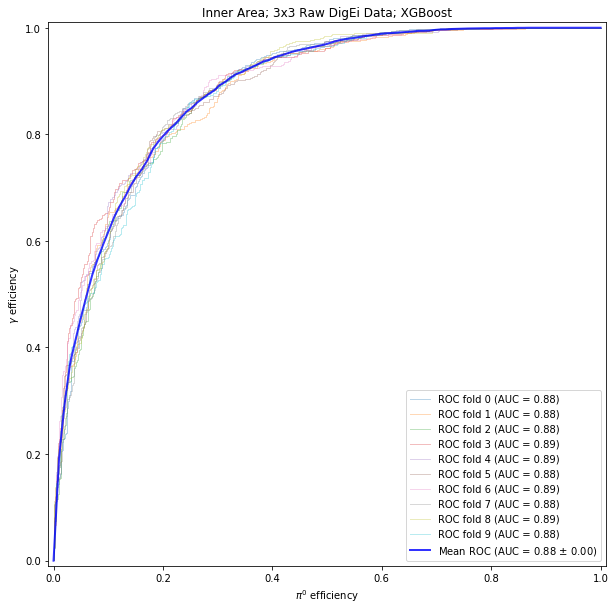

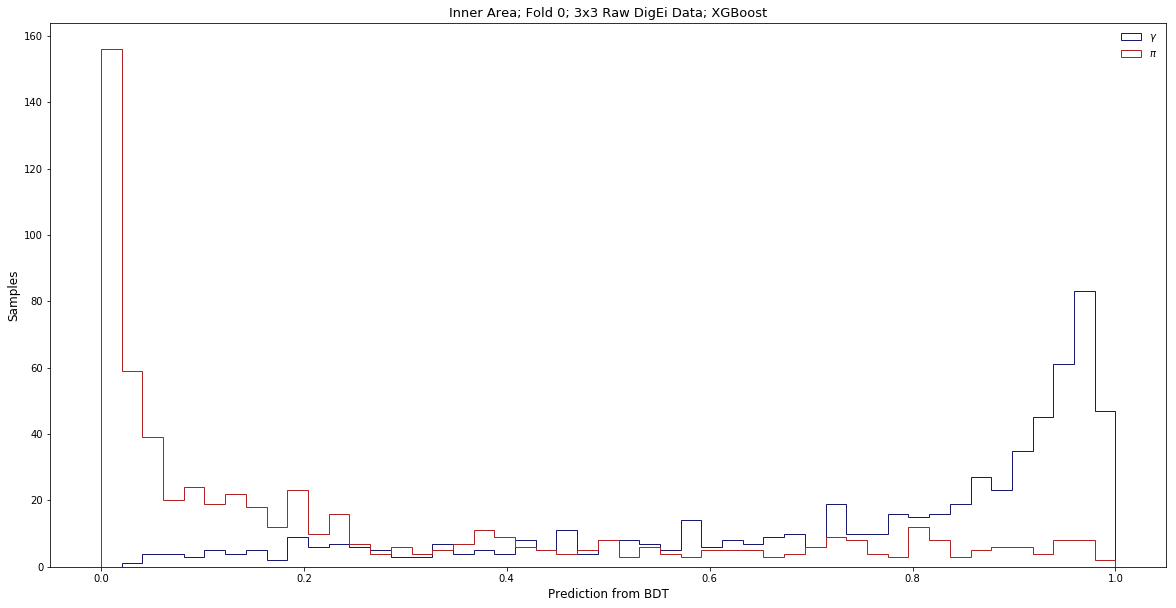

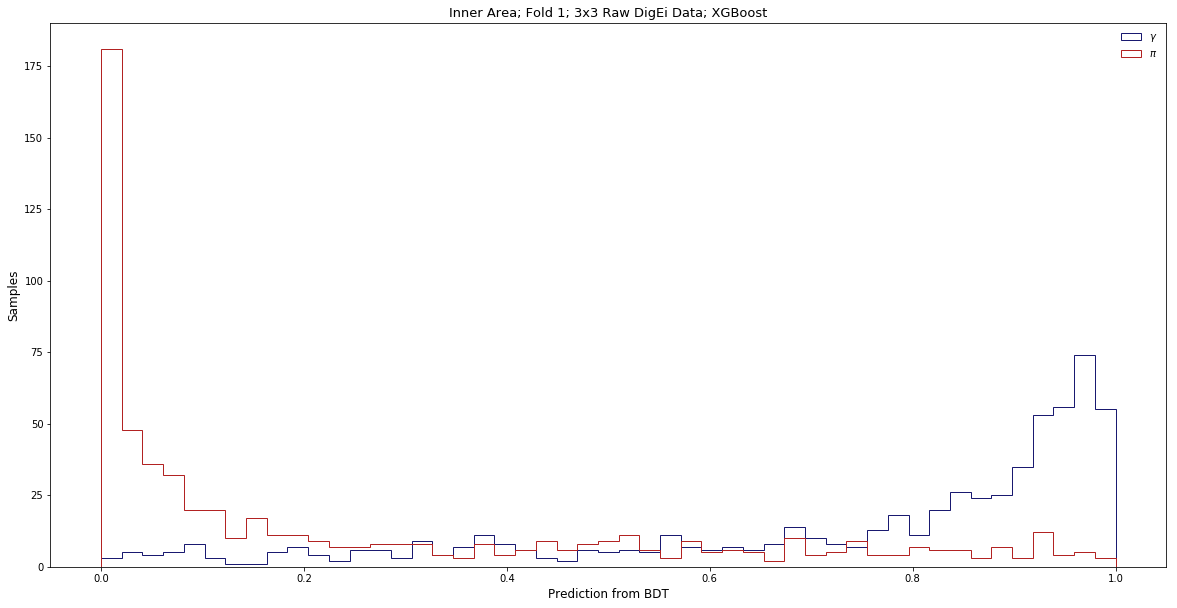

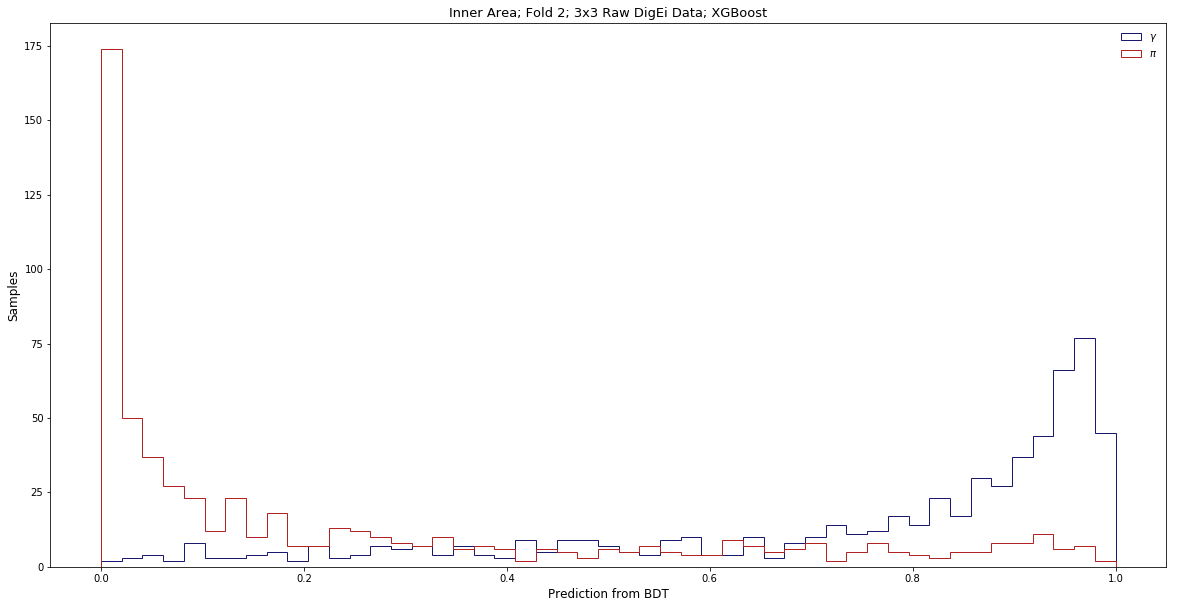

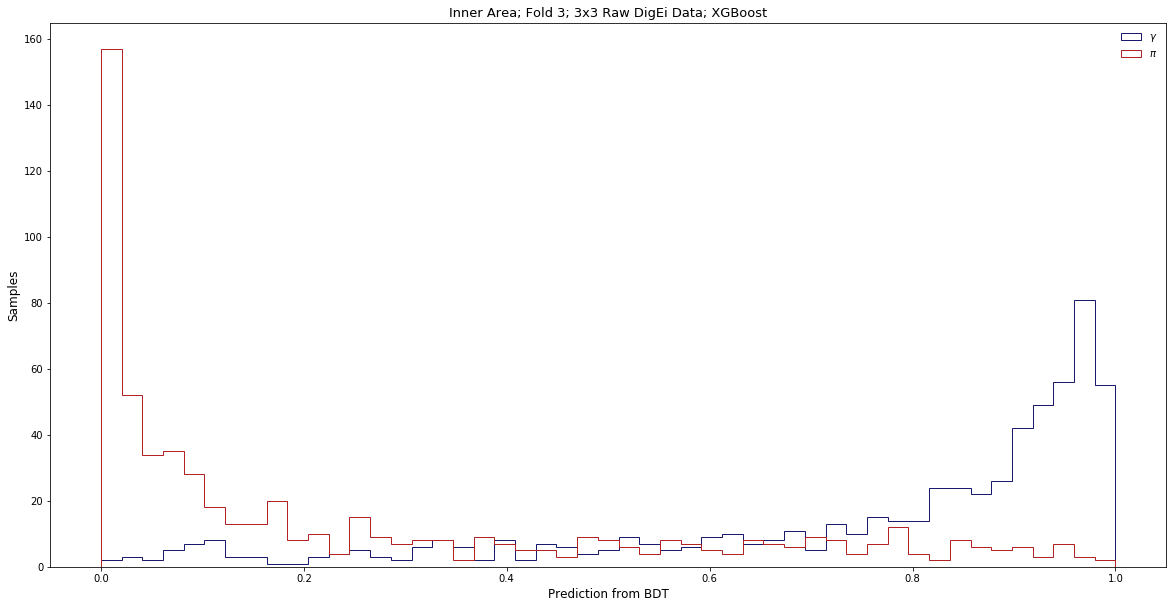

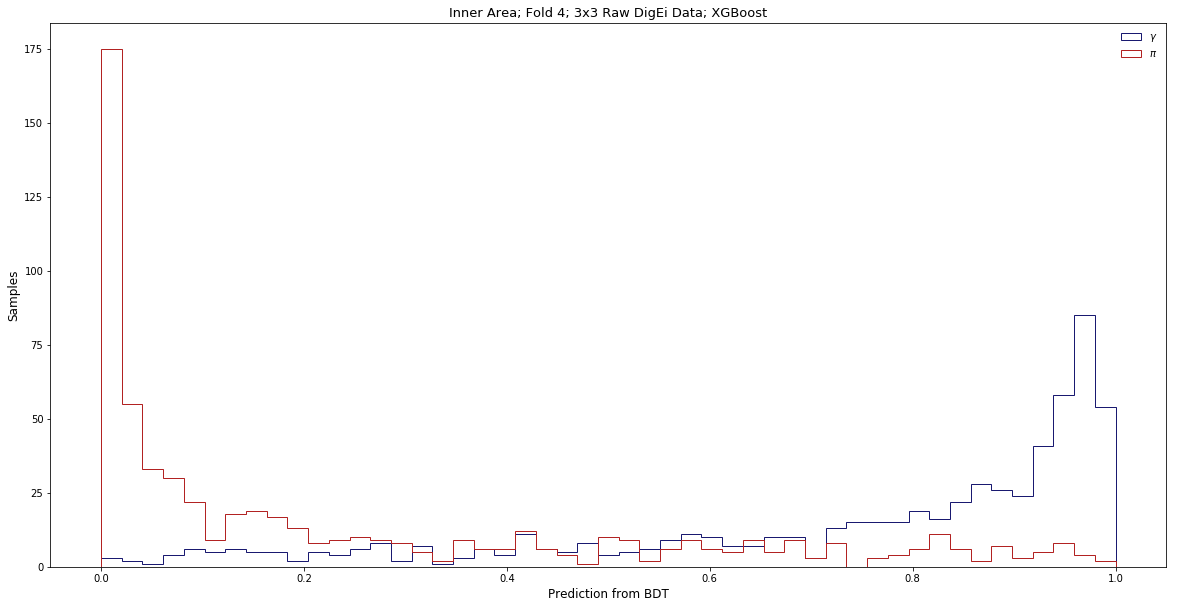

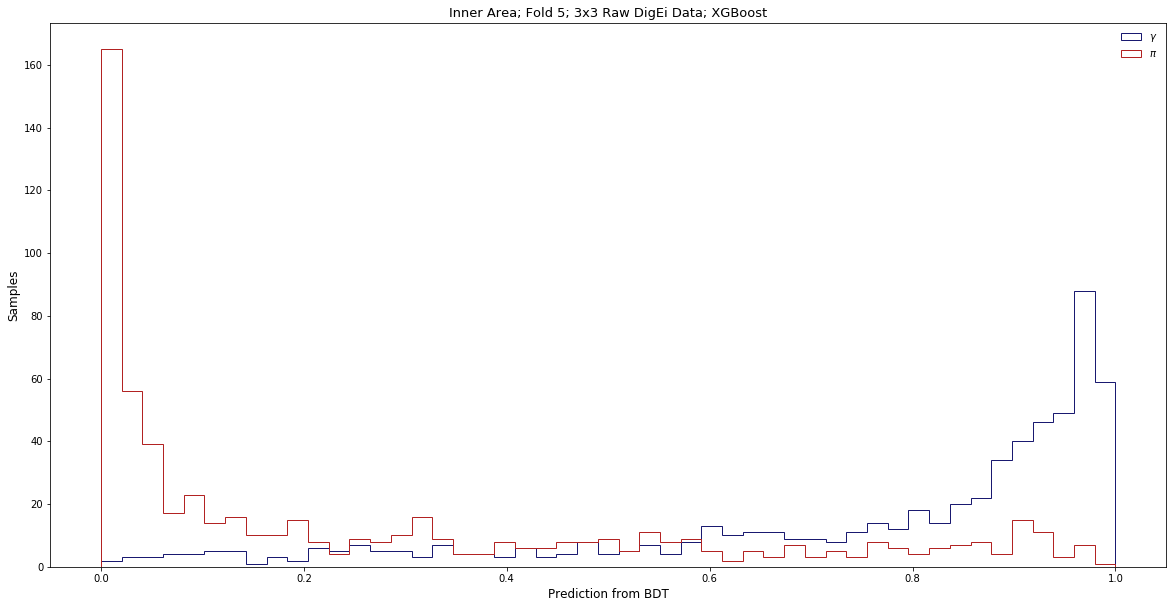

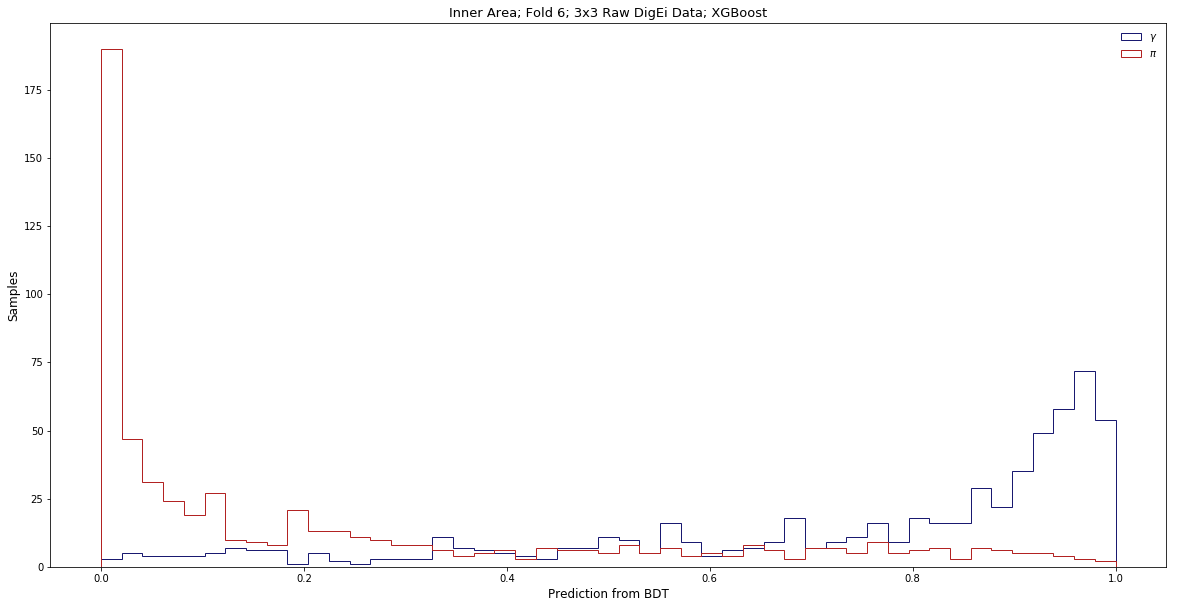

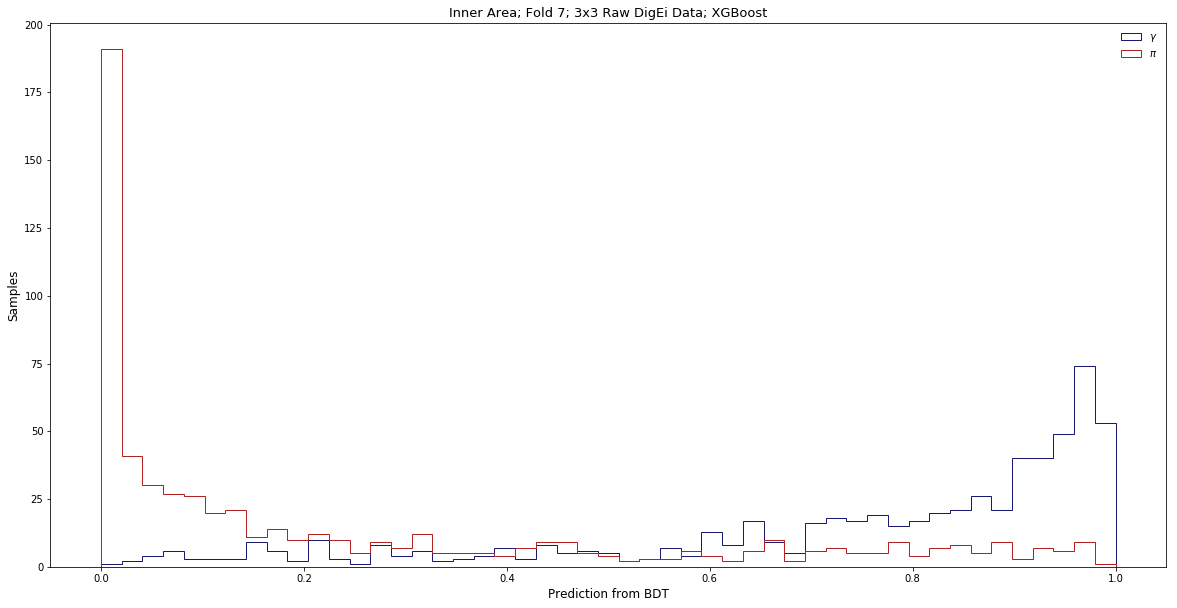

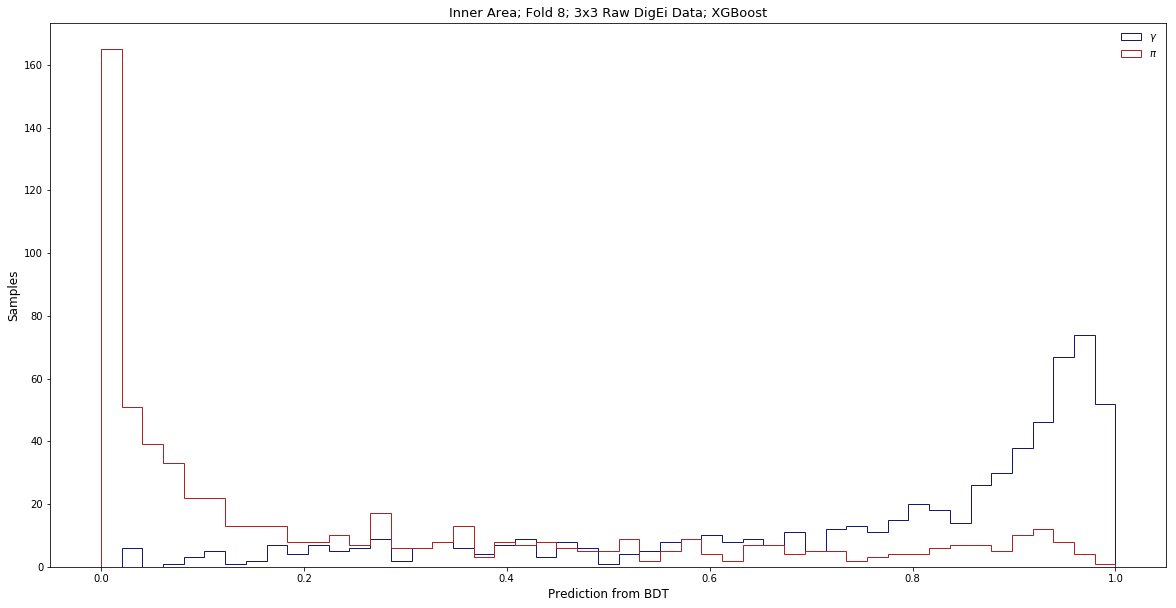

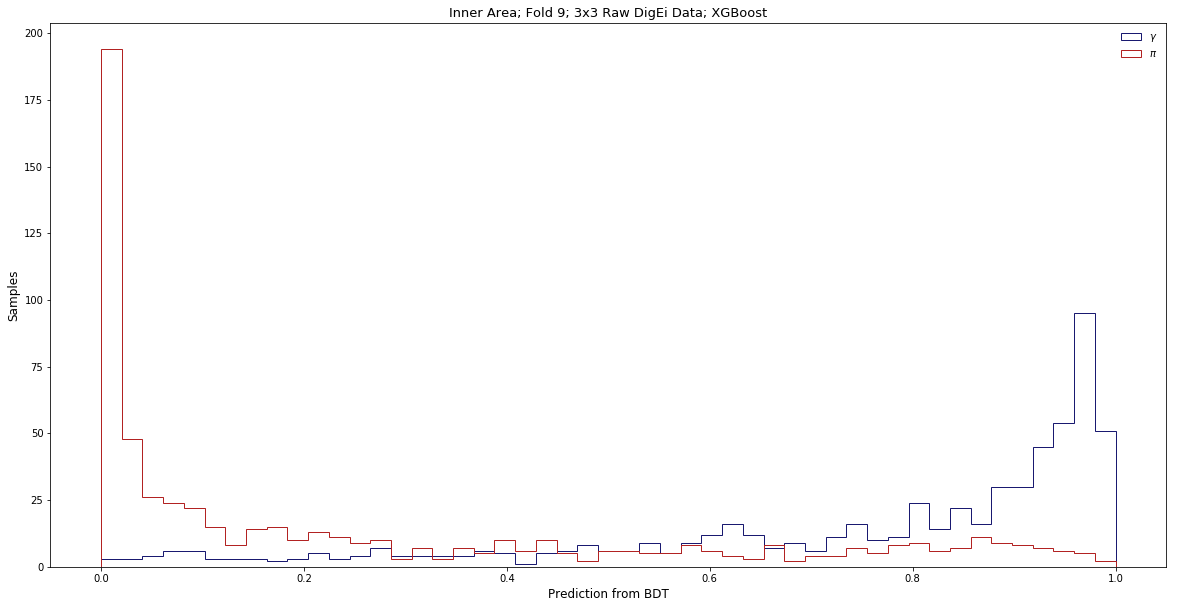

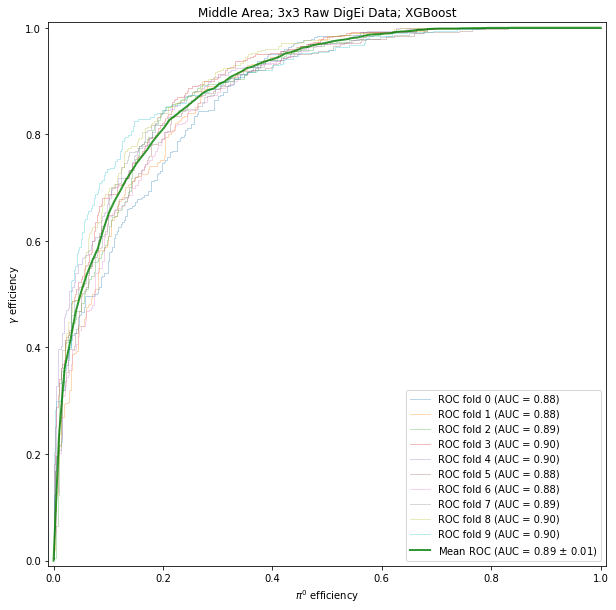

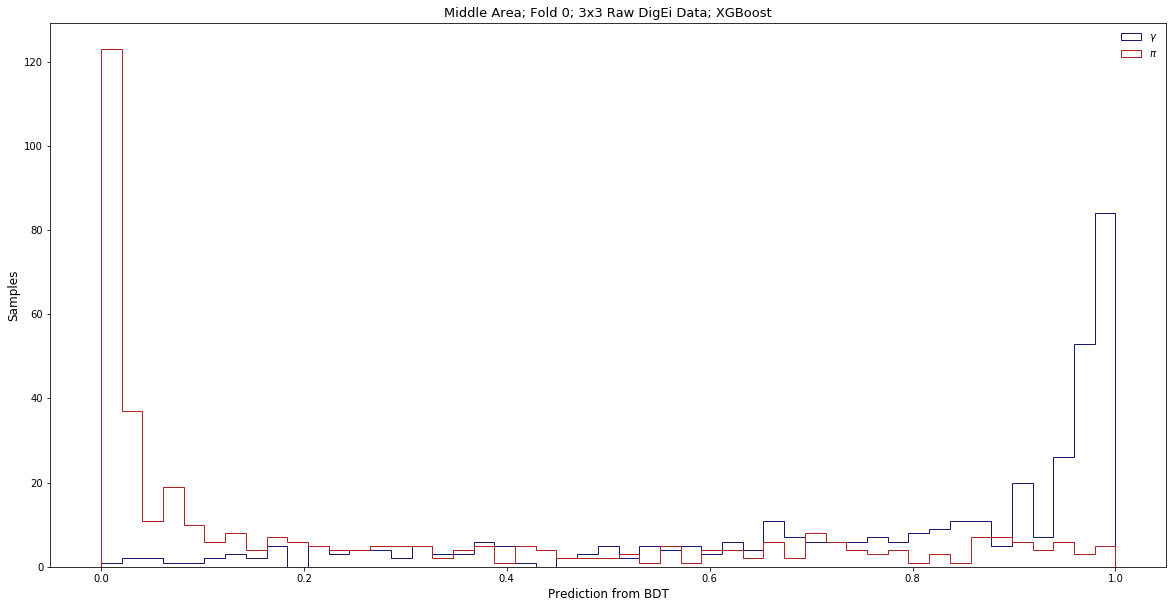

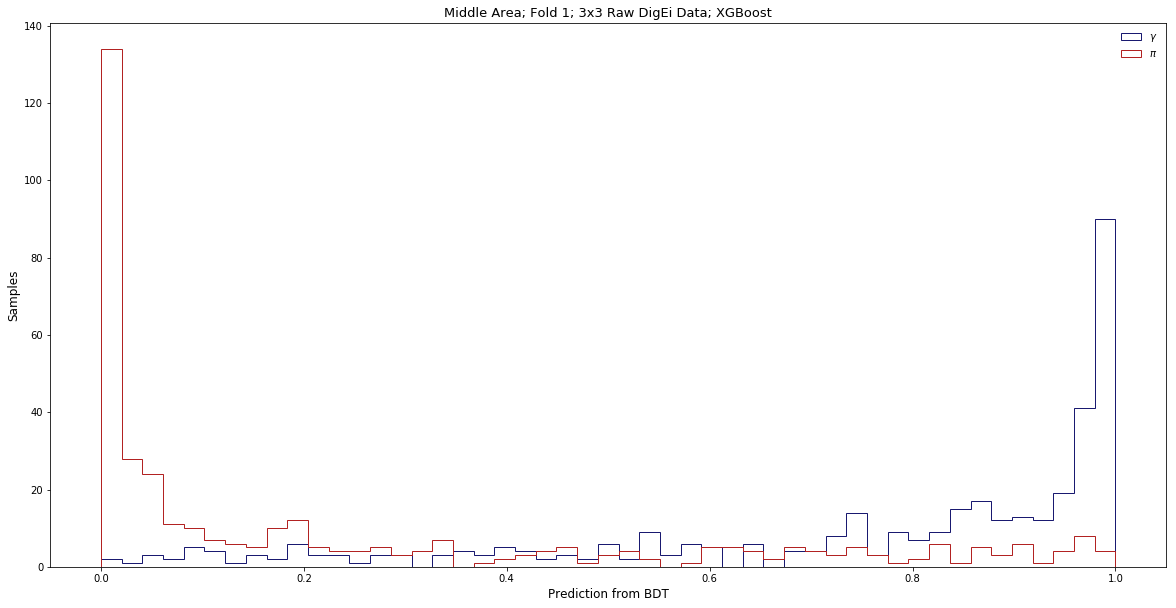

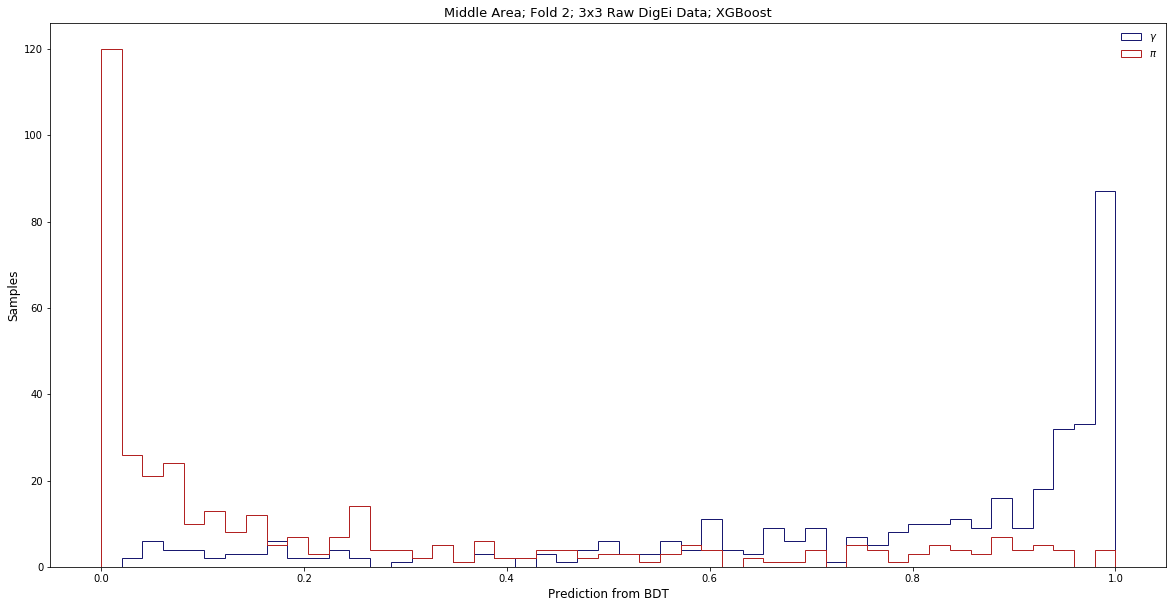

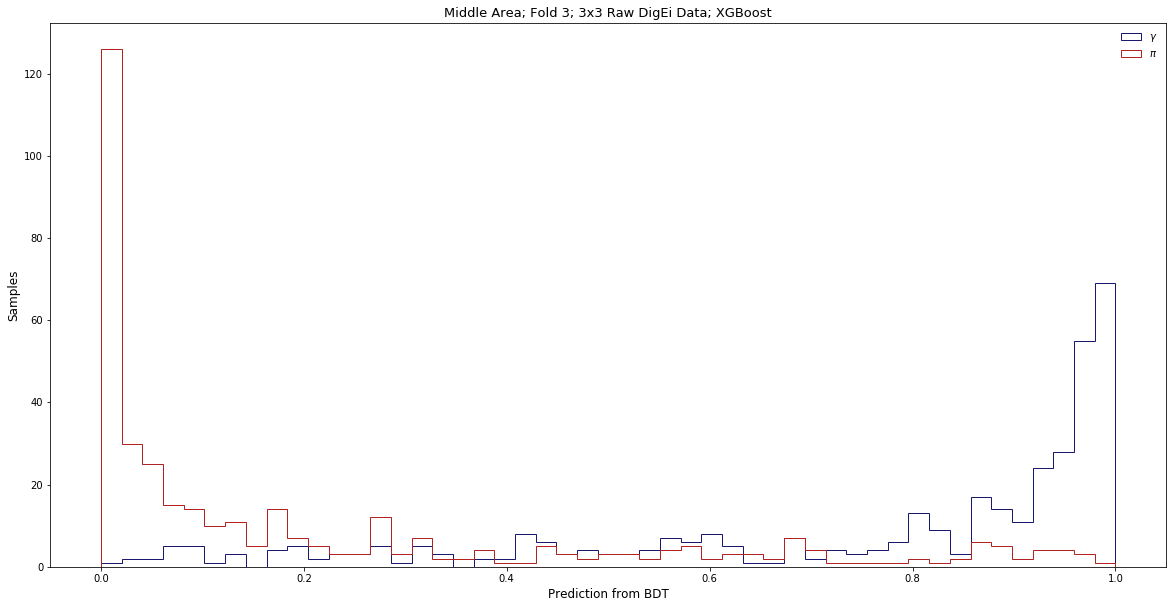

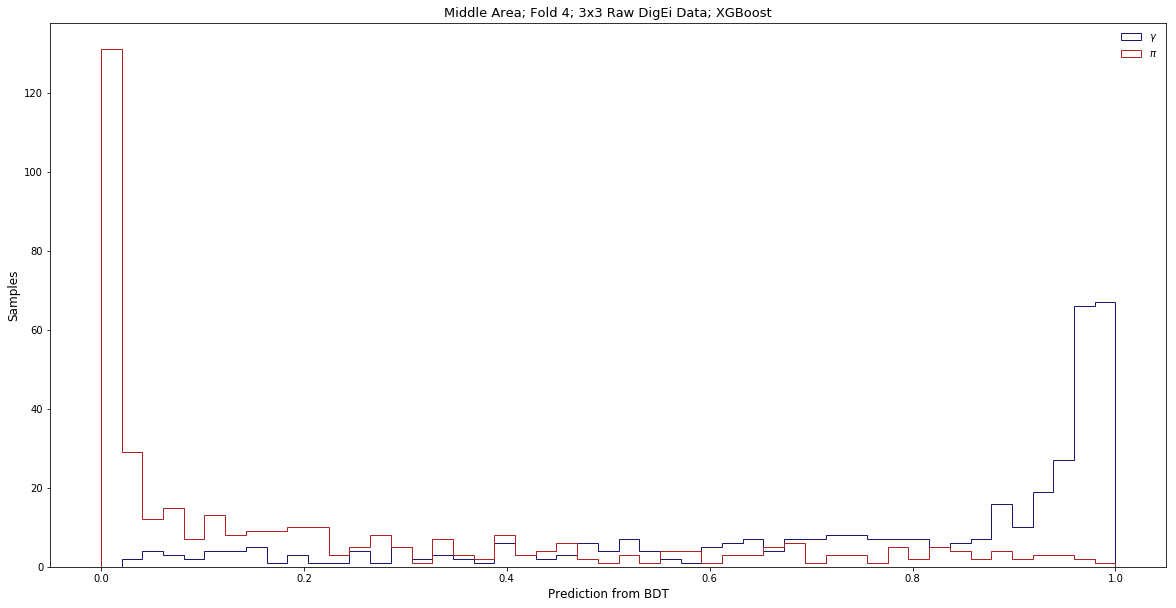

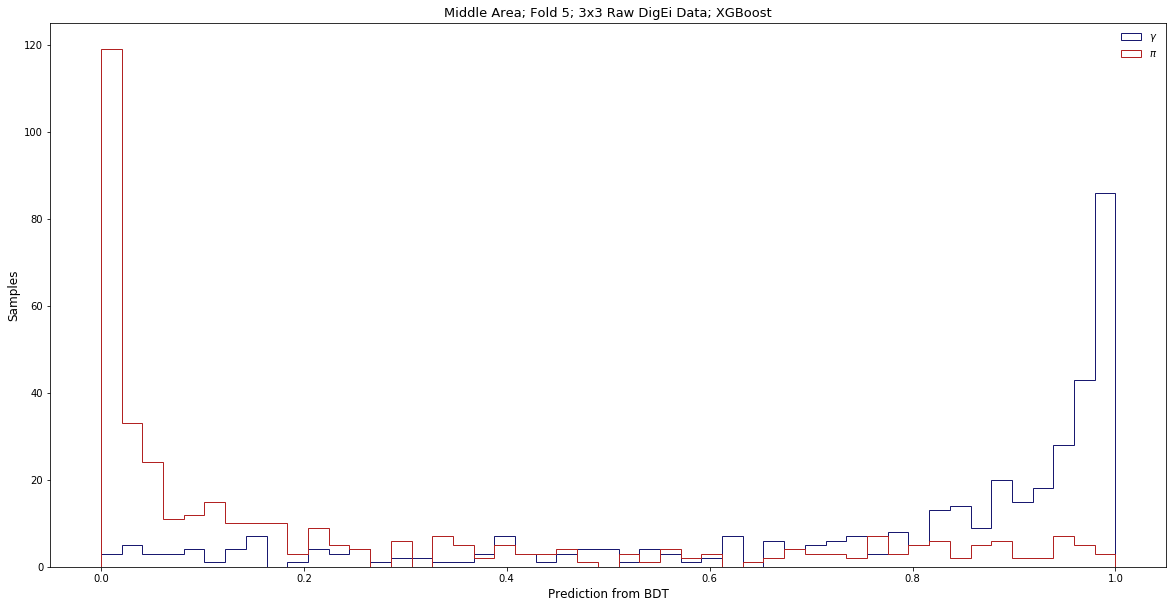

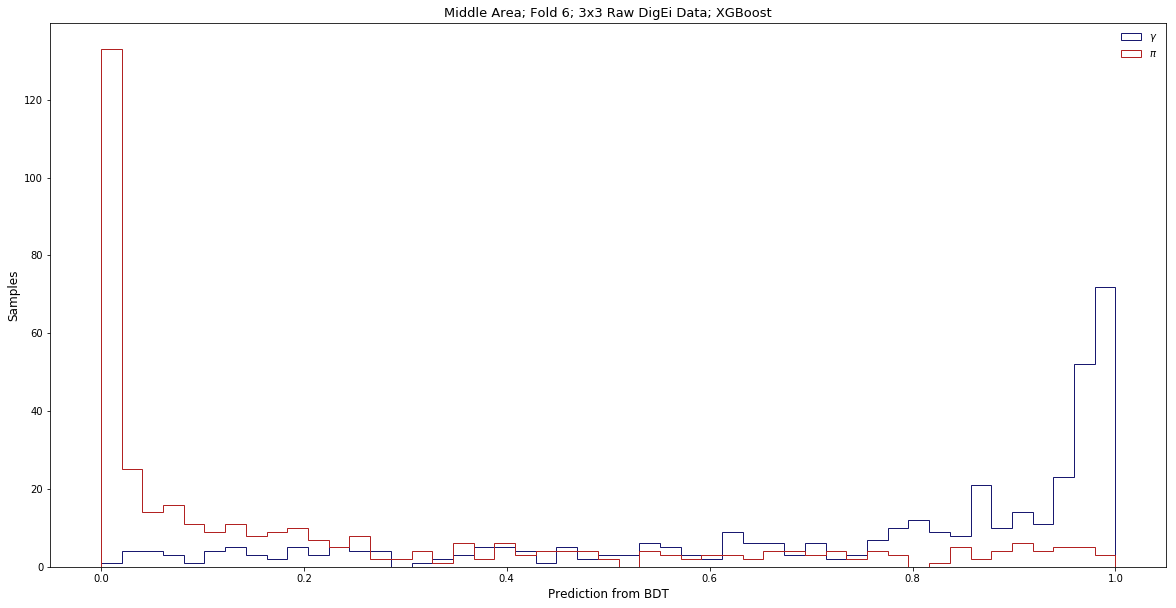

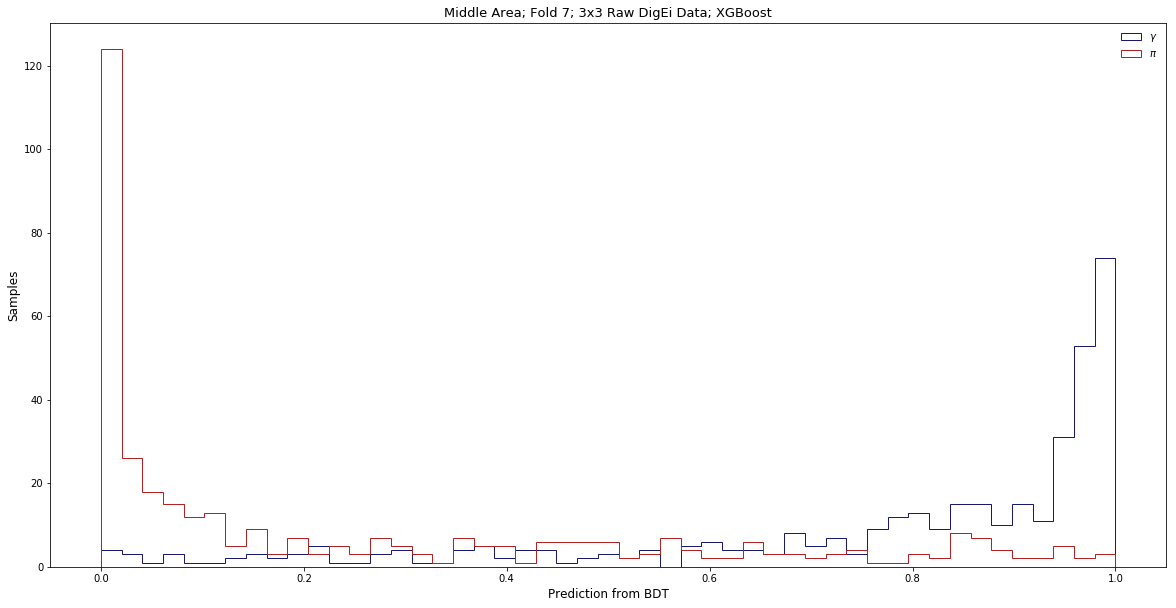

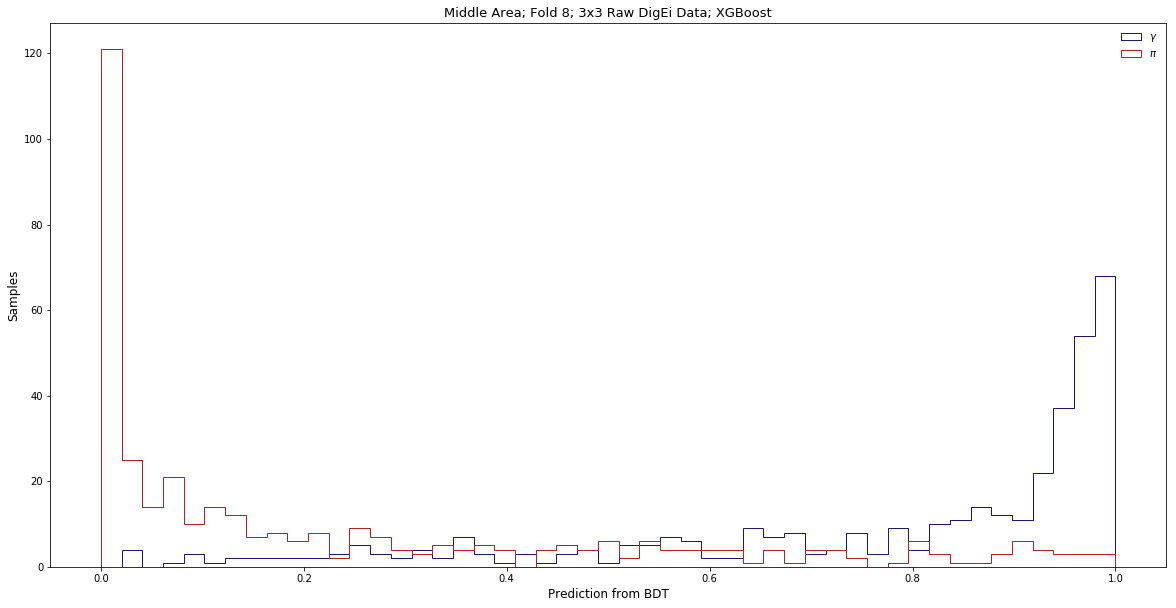

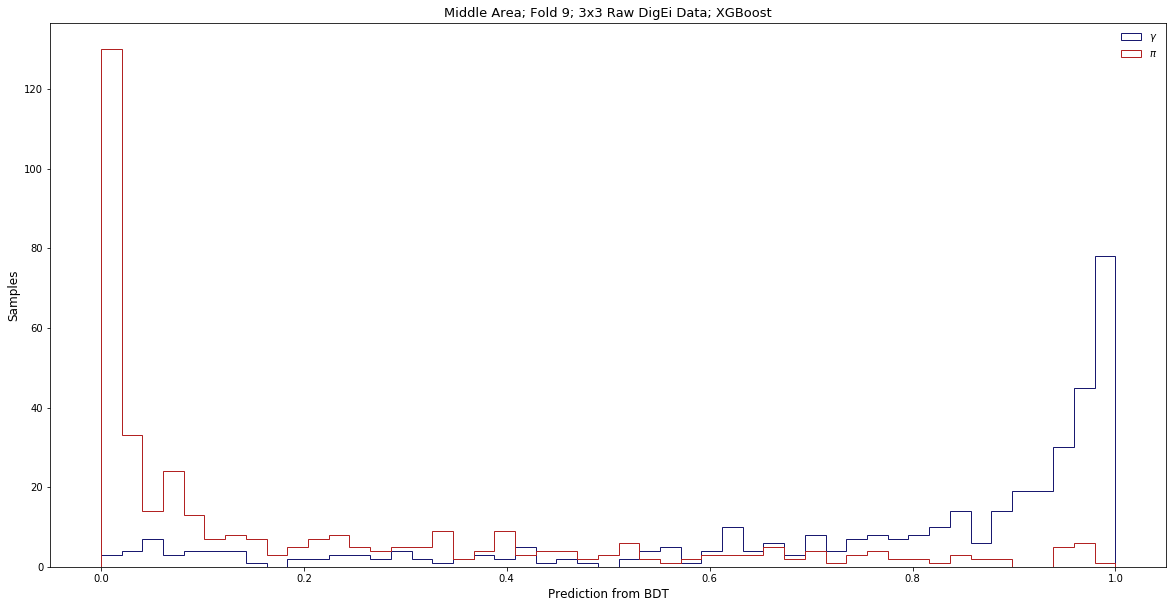

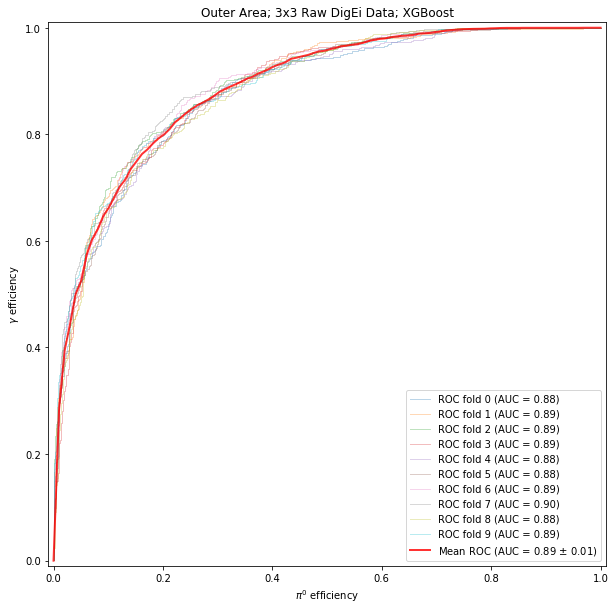

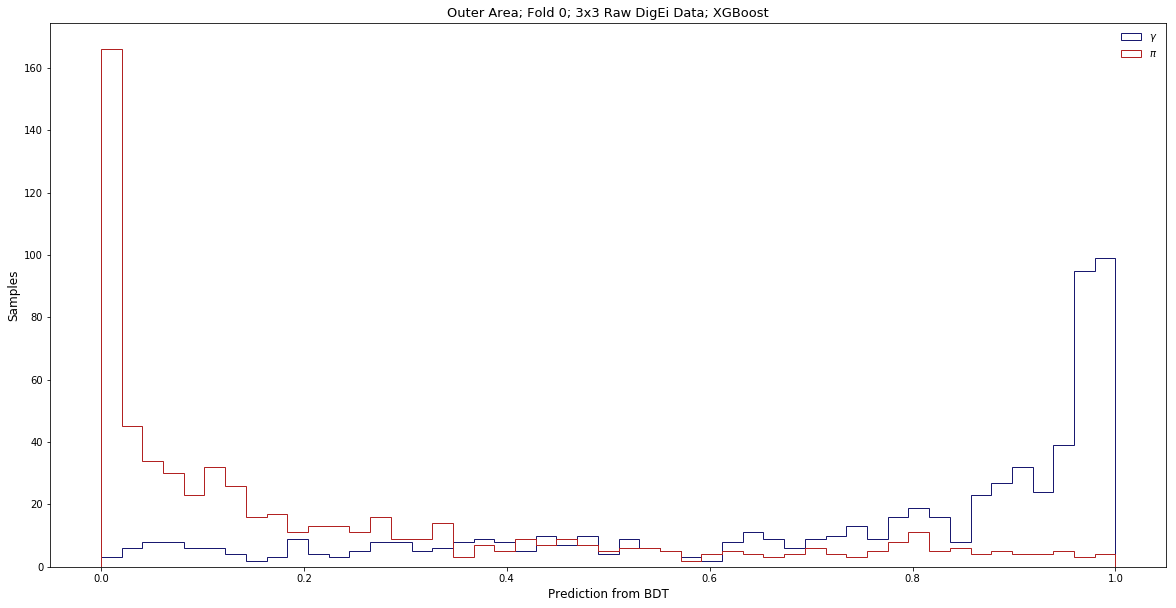

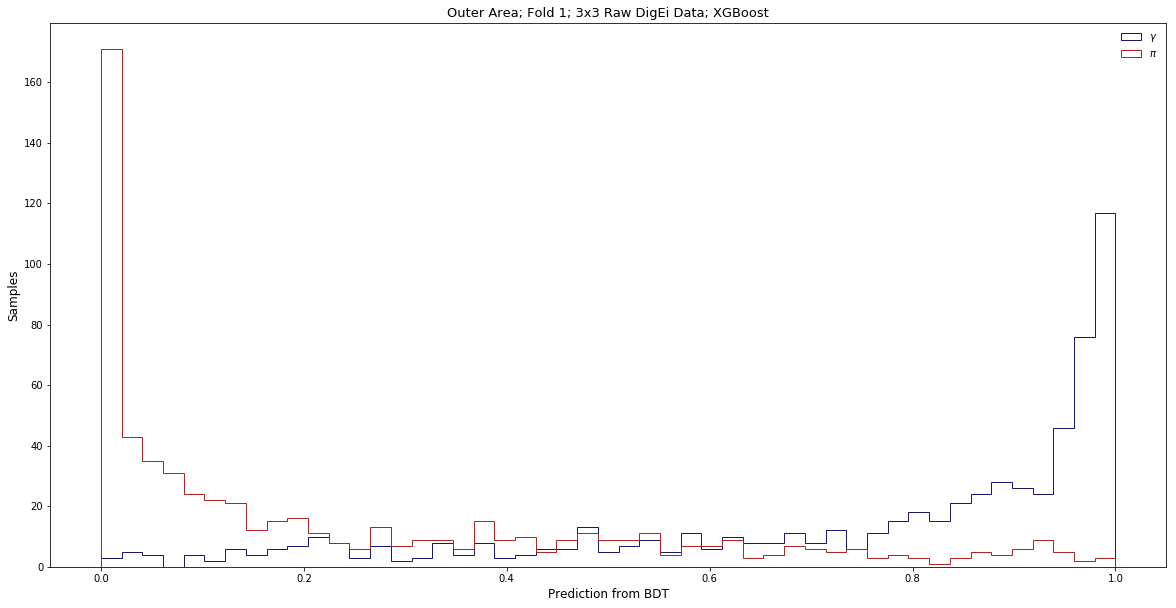

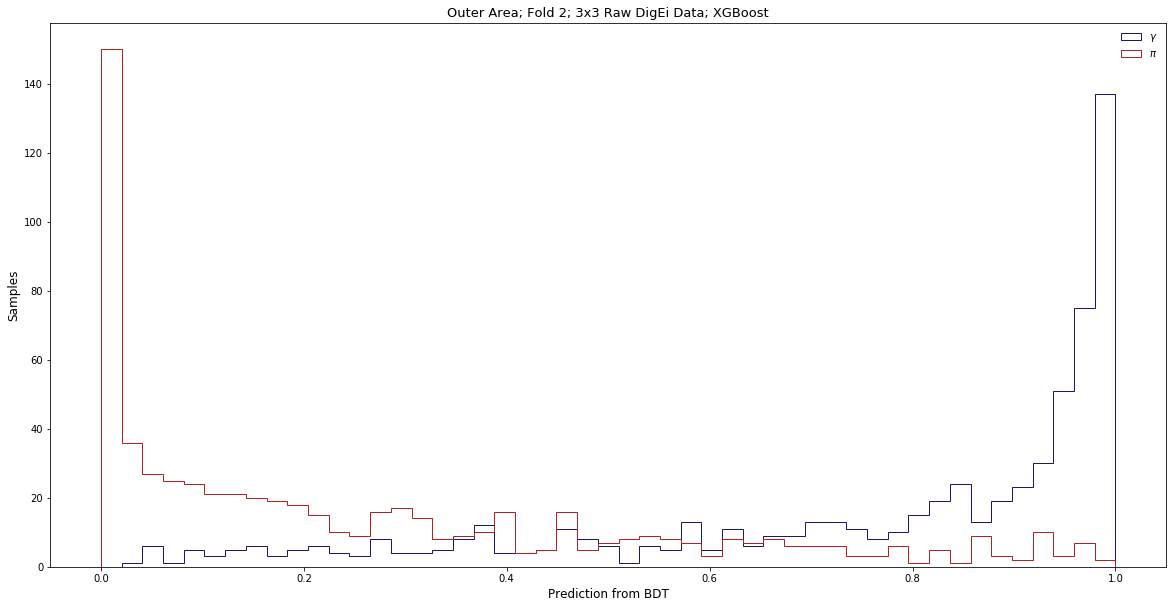

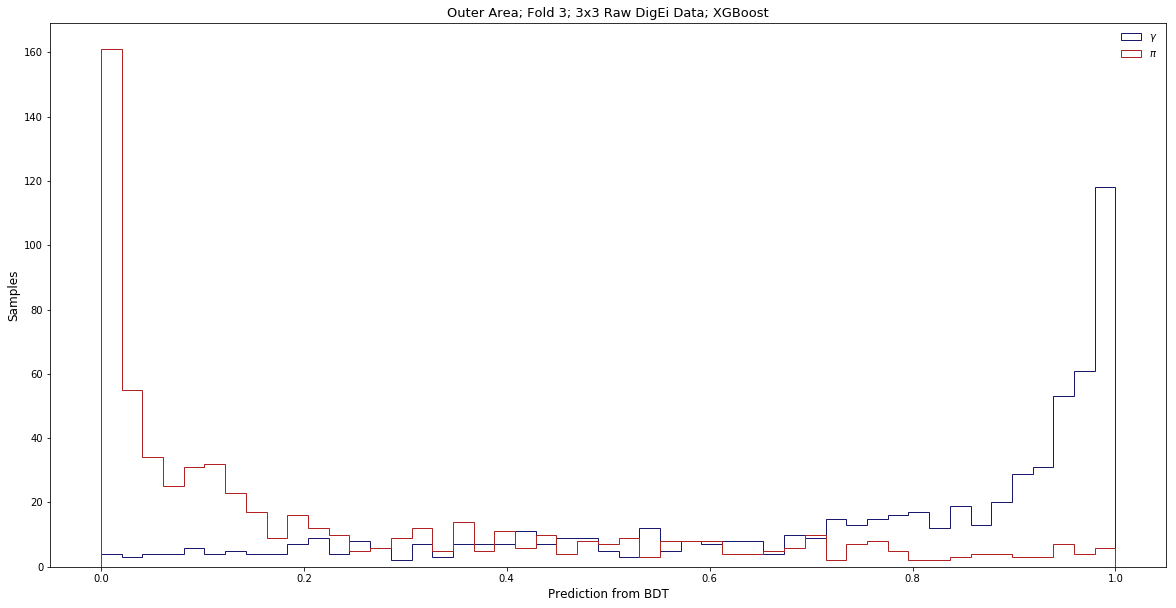

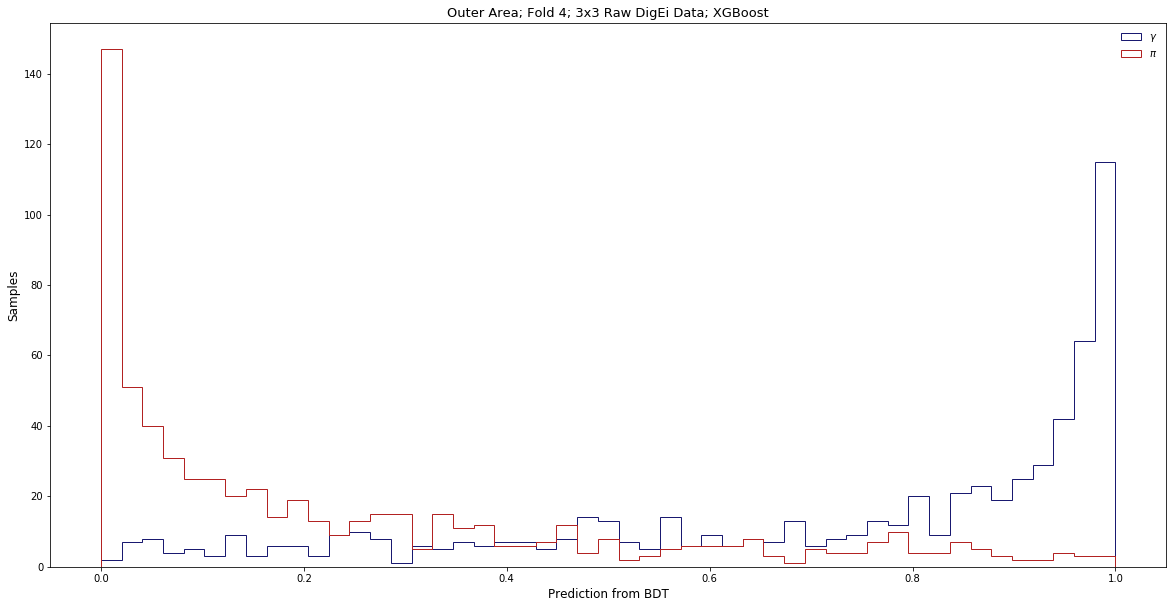

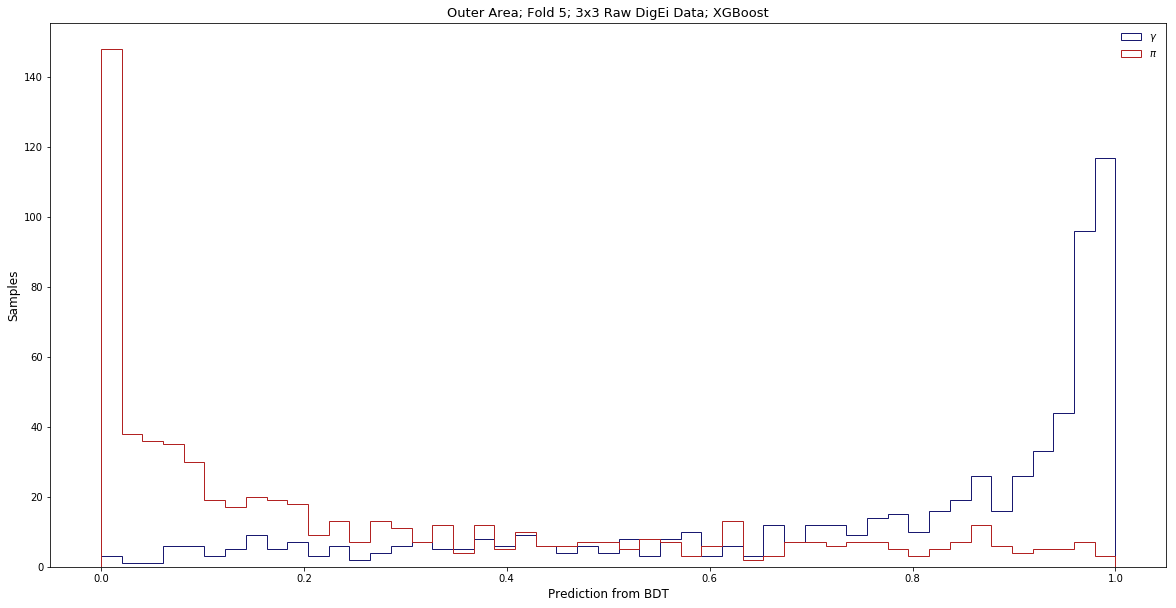

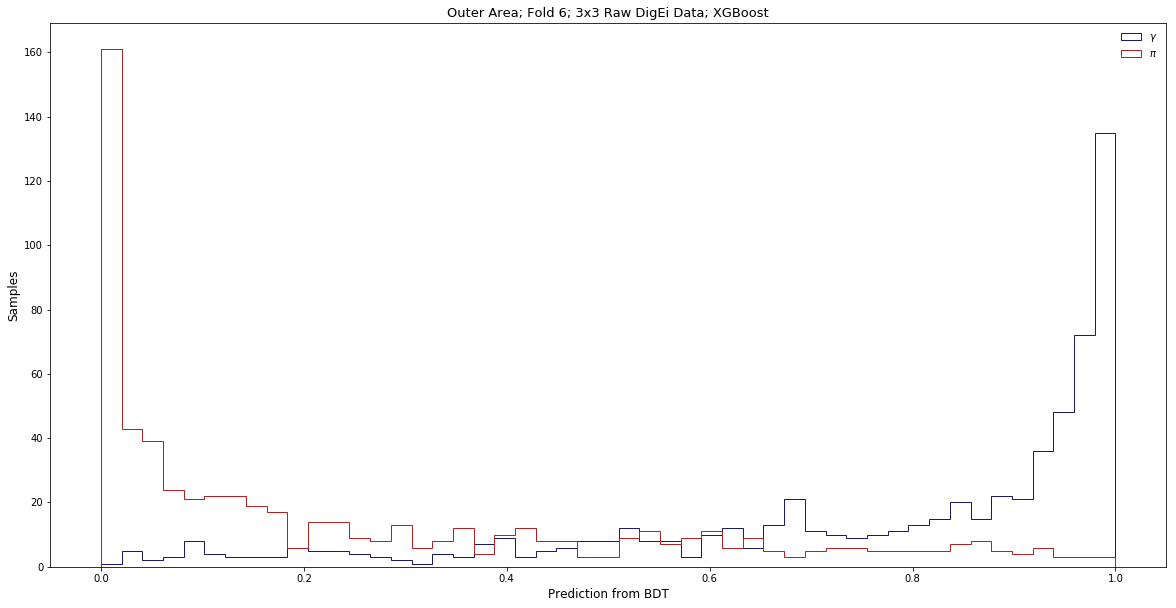

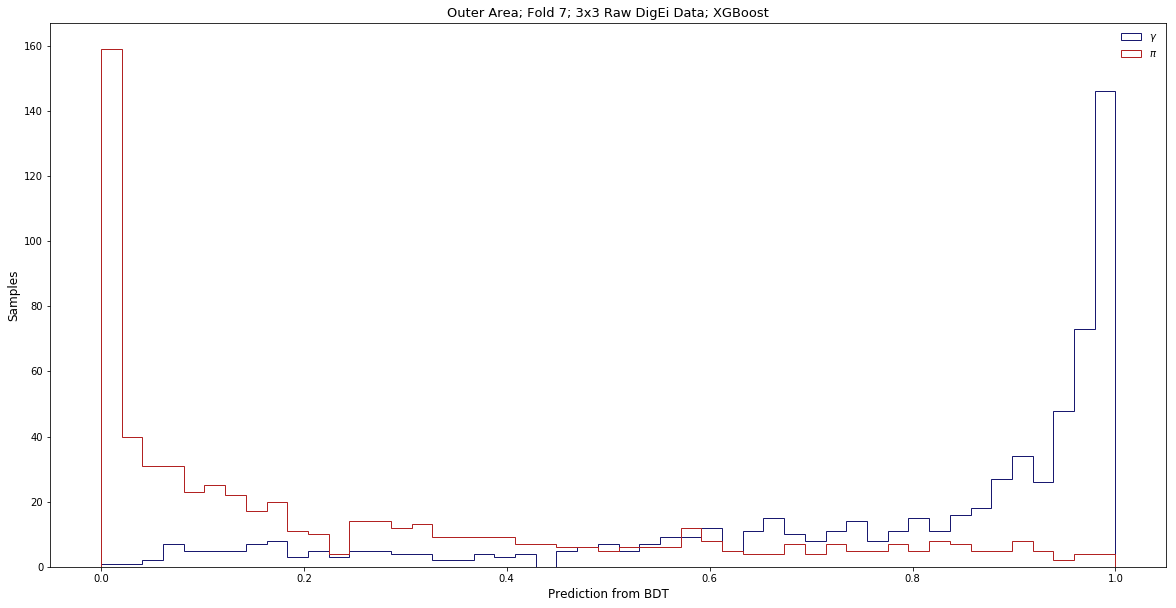

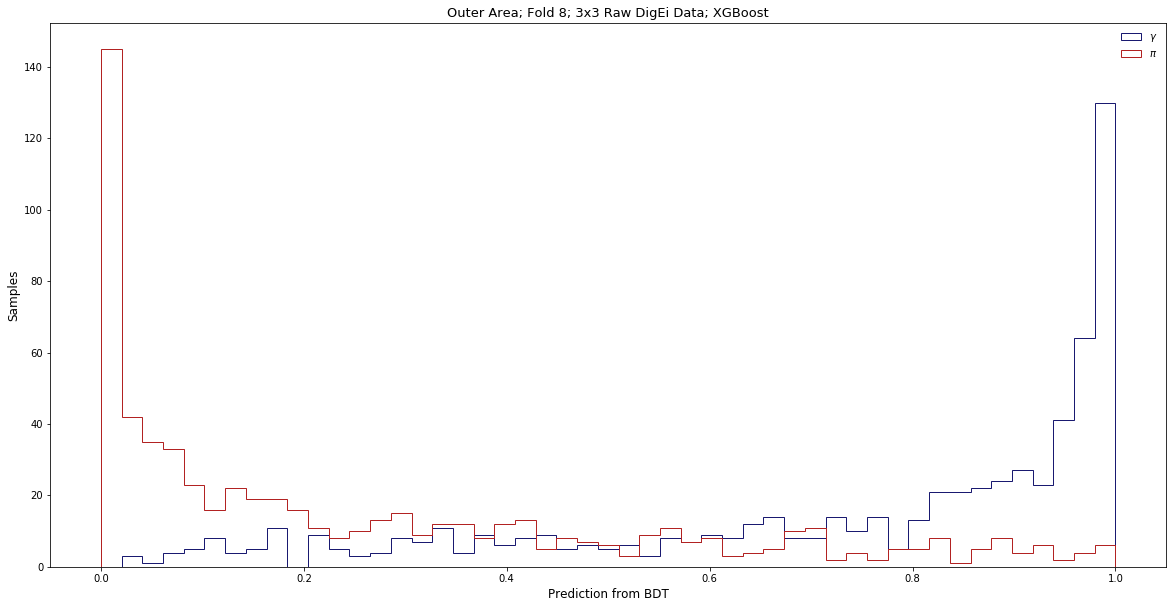

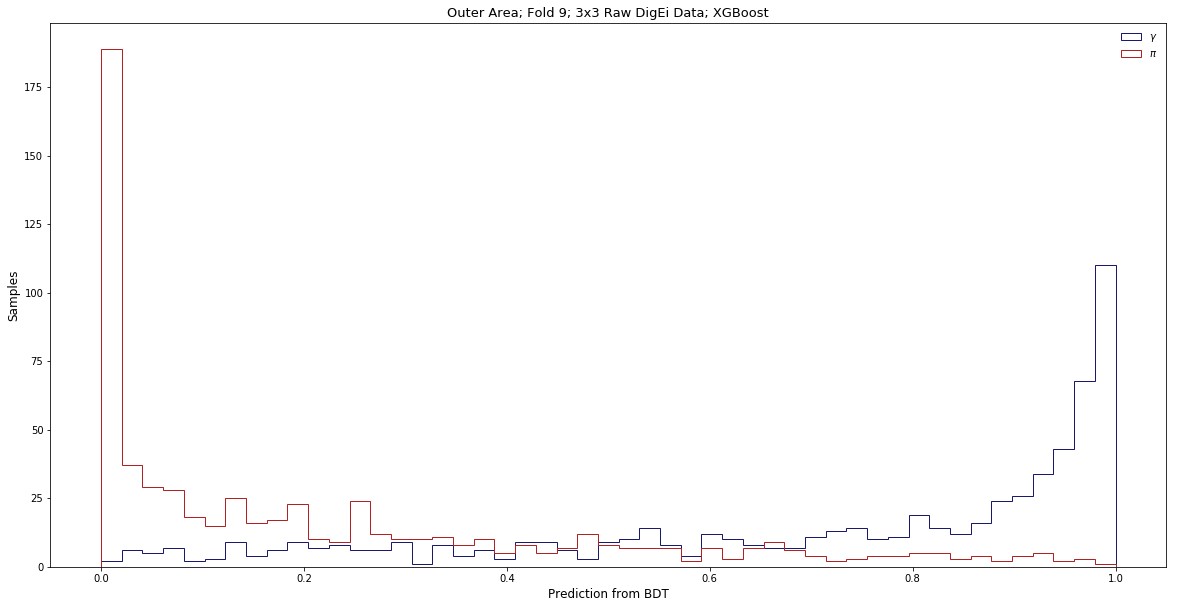

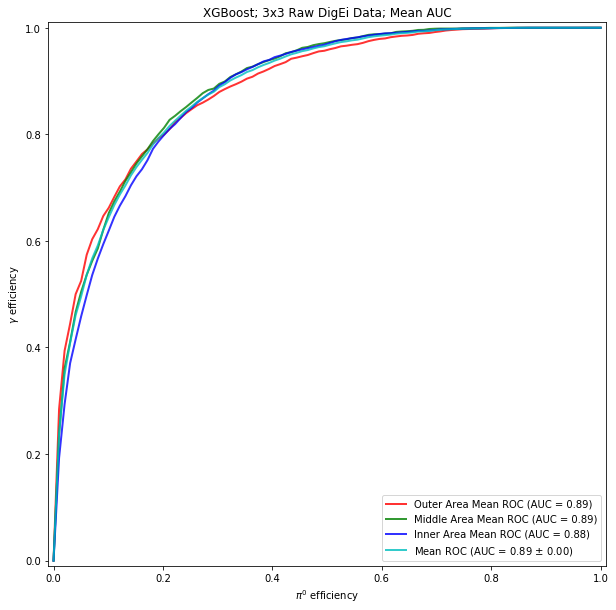

In [25]:
if save_results:
    save_models()
    reproduce_results(save_results_path)